In [80]:
import networkx as nx
import numpy as np
from collections import Counter
import multiprocessing as mp
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from torch_geometric.utils import from_networkx
import torch
from torch_geometric.data import Data
from collections import defaultdict
import torch_geometric

In [5]:
gw = nx.read_edgelist('./data/web-Google.txt', comments='#')

In [134]:
def cycle_count_radius(node, G=gw, radius=2):
    _g = nx.ego_graph(G, node, radius=2)
    return (node, Counter(map(len, nx.cycle_basis(_g, node))))

def triangle_count(g):
    """ Chiba-Nishizeki https://www.ecei.tohoku.ac.jp/alg/nishizeki/sub/j/DVD/PDF_J/J053.pdf 
    
    TODO: Convert this to layers of RHN
    """
    gw = g.copy()
    degree = nx.degree(gw)
    nodes_sorted = sorted(gw.nodes(), key=lambda u: -degree[u])

    num_triangles = {u: 0 for u in gw.nodes()}
    done = defaultdict(bool)
    marked = defaultdict(bool)
    for u in nodes_sorted:
        marked_nodes = []
        for v in gw.neighbors(u):
            marked[v] = True
            marked_nodes.append(v)
        for v in marked_nodes:
            for w in gw.neighbors(v):
                if marked[w]:
                    # (u, v, w) forms a triangle
                    num_triangles[u] += 1
                    num_triangles[v] += 1
                    num_triangles[w] += 1
                    # 26 num_triangles[u] += f(x_u) * g(x_v) * g(x_w) 
                    # hom[v] += f(x_v) * g(x_u) * g(x_w)
                    # use linear layer for f and g : exp(Ax) 
                    # final eq exp(sum of nodes) 
                    # exp(Ax_u + Bx_v + Bx_w) 
                    # Run on Cora / Citeseer / Pubmed
        for v in marked_nodes:
            marked[v] = False
        gw.remove_node(u)
    return num_triangles


def quadrangle_count(g):
    """ Chiba-Nishizeki https://www.ecei.tohoku.ac.jp/alg/nishizeki/sub/j/DVD/PDF_J/J053.pdf """
    gw = g.copy()
    degree = nx.degree(gw)
    nodes_sorted = sorted(gw.nodes(), key=lambda u: -degree[u])
    quadrangle = []
    U = {n: set() for n in gw.nodes()}
    for v in nodes_sorted:
        candidates = set()
        for u in gw.neighbors(v):
            for w in gw.neighbors(u):
                candidates.add(w)
                if w == v:
                    continue
                U[w].add(u)
            for c in candidates:
                if len(U[c]) >= 2:
                    quadrangle.append((v, w, tuple(U[c])))
                U[c] = set()
        gw.remove_node(v)
    return quadrangle

In [135]:
t = nx.from_edgelist([
    (5,10), (5,2), (5,7), (2,7), (2,1), (2,4), (7,1), (10,1), (1,3), (4,3), (4,8), (8,3), (3,6), (8,6), (4,9), (6,9)
])

In [82]:
cora = torch_geometric.datasets.Planetoid(root='./data/', name='Cora')

Processing...
Done!


In [83]:
corax = torch_geometric.utils.convert.to_networkx(cora)

AttributeError: 'Planetoid' object has no attribute 'node_offsets'

In [87]:
cora_edge = [*zip(*cora.edge_index.numpy())]

In [89]:
corax = nx.from_edgelist(cora_edge)

In [90]:
max(nx.core_number(corax).values())

4

In [93]:
degs = [d for n, d in corax.degree()]

In [94]:
np.mean(degs)

3.8980797636632203

In [95]:
np.max(degs)

168

In [105]:
np.argmax(degs)

127

In [113]:
cnodes = list(corax.nodes())

In [114]:
cnodes[127]

1358

In [115]:
nx.clustering(corax)[1358]

0.01140575990875392

In [116]:
t = nx.ego_graph(corax, 1358)

In [123]:
mapping = {n: i for i, n in enumerate(corax.nodes())}

In [124]:
neighs = [mapping[n] for n in t.nodes()]

In [126]:
labels_neighs = cora.y[neighs].

In [127]:
labels_neighs

tensor([0, 5, 3, 0, 0, 4, 2, 4, 4, 5, 0, 3, 2, 3, 4, 4, 1, 4, 3, 4, 3, 6, 4, 3,
        3, 5, 6, 2, 3, 2, 4, 5, 5, 2, 4, 5, 2, 3, 0, 4, 5, 2, 1, 3, 2, 0, 3, 3,
        3, 0, 3, 3, 4, 3, 2, 3, 2, 2, 2, 2, 6, 6, 5, 0, 3, 4, 4, 0, 3, 4, 4, 4,
        2, 3, 3, 5, 2, 0, 0, 6, 1, 0, 4, 1, 6, 4, 5, 3, 3, 3, 3, 3, 3, 5, 3, 3,
        2, 3, 3, 4, 4, 0, 0, 5, 3, 3, 1, 5, 6, 3, 1, 4, 3, 0, 3, 2, 2, 4, 3, 3,
        3, 2, 5, 5, 5, 3, 5, 3, 0, 5, 0, 3, 2, 3, 4, 2, 2, 0, 6, 3, 3, 1, 0, 3,
        4, 3, 4, 3, 3, 1, 3, 4, 6, 3, 3, 3, 2, 0, 4, 3, 0, 3, 6, 3, 3, 4, 3, 3,
        6])

In [128]:
mapping[1358]

127

In [129]:
cora.y[127]

tensor(6)

In [132]:
t.nodes()

NodeView((1546, 1732, 524, 1038, 1550, 1040, 1041, 1562, 1565, 30, 1568, 34, 2597, 552, 1070, 1072, 53, 1741, 59, 1599, 68, 580, 1604, 72, 73, 1103, 1746, 1620, 90, 609, 1123, 101, 613, 616, 1646, 111, 626, 1145, 1149, 1755, 1154, 645, 1169, 1759, 154, 155, 156, 1189, 1763, 170, 684, 173, 174, 686, 687, 689, 1708, 1709, 1710, 1205, 1711, 1712, 1713, 1209, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723, 708, 1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1229, 1733, 1734, 1735, 1736, 1737, 1738, 1739, 1740, 1238, 1742, 1743, 1744, 1745, 1243, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 228, 1756, 1757, 1758, 744, 1760, 1761, 1762, 748, 1764, 1765, 1766, 754, 244, 757, 246, 758, 764, 1281, 1284, 1287, 1292, 1305, 796, 797, 289, 819, 823, 1339, 831, 326, 333, 1358, 337, 341, 853, 346, 357, 1384, 873, 364, 876, 1389, 882, 902, 919, 929, 1444, 951, 957, 1471, 1480, 970, 1483, 466, 978, 1492, 985, 1499, 999, 489, 1516, 501))

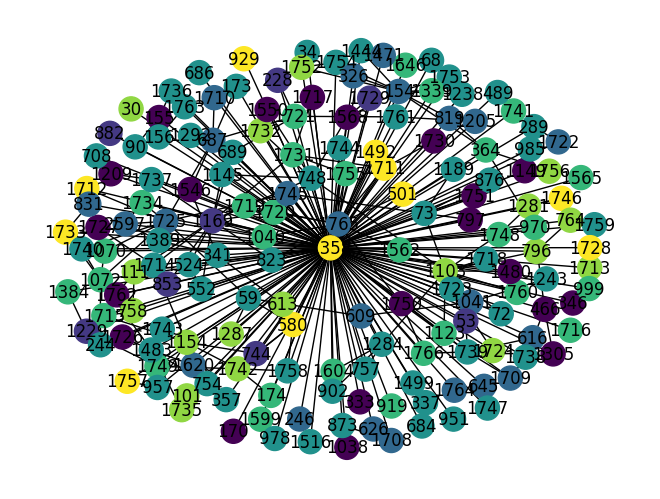

In [131]:
nx.draw(t, with_labels=True, node_color=labels_neighs.numpy())

In [122]:
cora.y.numpy()

array([3, 4, 4, ..., 3, 3, 3])

In [104]:
np.mean(list(nx.clustering(corax).values()))

0.24067329850193736

In [7]:
%%time

nodes = list(gw.nodes())

# Expect 2 hours
with mp.Pool(16) as p:
    results = p.map(cycle_count_radius, nodes)

CPU times: user 13.2 s, sys: 874 ms, total: 14.1 s
Wall time: 1h 11min 35s


In [8]:
len(results)

875713

In [42]:
gw.number_of_nodes()

875713

In [41]:
gw.number_of_edges()

4322051

In [27]:
with open('./google-r2-count.pkl', 'wb') as f:
    pkl.dump(results, f)

In [47]:
deg = np.array([d for i, d in gw.degree()])

In [28]:
c3counts =  np.array([counts[3] for (node, counts) in results])
c4counts =  np.array([counts[4] for (node, counts) in results])

In [49]:
deg.mean()

9.870930316210904

In [50]:
deg.max()

6332

In [54]:
[r for (i, r) in results if i == '4']

[Counter({3: 17772,
          4: 617,
          5: 141,
          63: 109,
          6: 99,
          7: 60,
          12: 52,
          30: 49,
          13: 47,
          9: 36,
          14: 29,
          50: 29,
          8: 28,
          31: 28,
          35: 28,
          64: 28,
          33: 27,
          113: 25,
          15: 24,
          22: 21,
          38: 21,
          10: 21,
          11: 20,
          37: 19,
          58: 19,
          17: 18,
          44: 18,
          51: 17,
          21: 16,
          32: 16,
          36: 16,
          53: 16,
          16: 16,
          59: 16,
          90: 15,
          66: 15,
          19: 14,
          24: 13,
          60: 13,
          57: 13,
          20: 12,
          42: 12,
          52: 12,
          49: 12,
          26: 11,
          34: 11,
          25: 11,
          23: 11,
          45: 11,
          28: 10,
          65: 10,
          46: 10,
          18: 9,
          29: 9,
          67: 9,
          61:

In [55]:
test = nx.ego_graph(gw, '4', 2)

In [56]:
test.number_of_edges()

24004

In [57]:
test.number_of_nodes()

3996

In [58]:
test = nx.ego_graph(gw, '3', 2)
print(test.number_of_edges())
print(test.number_of_nodes())

69
26


In [64]:
nx.cycle_basis(test, root='3')

[['240941', '893009', '3'],
 ['231032', '470237', '893009'],
 ['240941', '470237', '893009'],
 ['299594', '470237', '893009', '3'],
 ['207872', '654000', '893009'],
 ['295728', '654000', '893009'],
 ['536301', '654000', '893009'],
 ['915965', '654000', '893009'],
 ['831856', '654000', '893009'],
 ['391951', '654000', '893009'],
 ['883770', '654000', '893009'],
 ['849626', '654000', '893009'],
 ['220132', '654000', '893009'],
 ['654749', '654000', '893009'],
 ['839713', '654000', '893009'],
 ['849626', '41680', '893009'],
 ['526724', '839713', '893009'],
 ['536301', '839713', '893009'],
 ['734915', '839713', '893009'],
 ['642996', '839713', '893009'],
 ['144084', '839713', '893009'],
 ['207872', '654749', '893009'],
 ['536301', '654749', '893009'],
 ['849626', '654749', '893009'],
 ['220132', '654749', '893009'],
 ['207872', '220132', '893009'],
 ['536301', '220132', '893009'],
 ['144084', '220132', '893009'],
 ['536301', '849626', '893009'],
 ['734915', '883770', '893009'],
 ['144084',

In [61]:
test.edges()

EdgeView([('657377', '144084'), ('657377', '231032'), ('657377', '893009'), ('526724', '734915'), ('526724', '839713'), ('526724', '893009'), ('684712', '893009'), ('207872', '220132'), ('207872', '654749'), ('207872', '893009'), ('207872', '536301'), ('207872', '654000'), ('295728', '893009'), ('295728', '536301'), ('295728', '654000'), ('536301', '839713'), ('536301', '893009'), ('536301', '220132'), ('536301', '654000'), ('536301', '654749'), ('536301', '831856'), ('536301', '849626'), ('231032', '144084'), ('231032', '470237'), ('231032', '893009'), ('734915', '144084'), ('734915', '642996'), ('734915', '839713'), ('734915', '893009'), ('734915', '883770'), ('915965', '893009'), ('915965', '654000'), ('642996', '144084'), ('642996', '839713'), ('642996', '893009'), ('831856', '893009'), ('831856', '654000'), ('831856', '391951'), ('3', '240941'), ('3', '299594'), ('3', '893009'), ('391951', '144084'), ('391951', '893009'), ('391951', '654000'), ('144084', '220132'), ('144084', '839

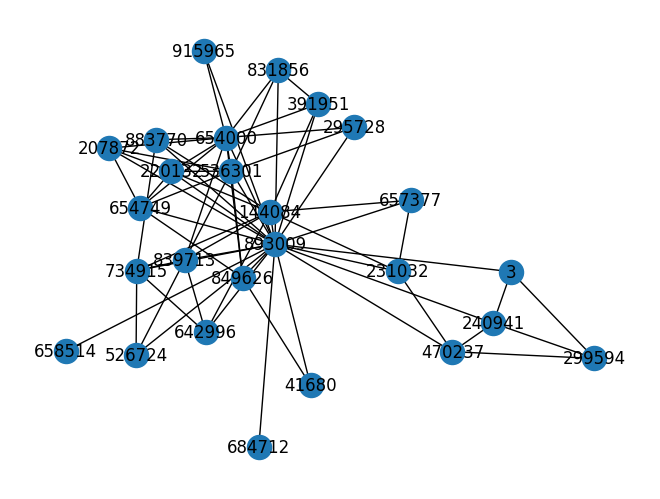

In [63]:
nx.draw(test, with_labels=True)

In [29]:
c3counts.mean()

6247.779269007084

In [30]:
c4counts.mean()

283.05490954228156

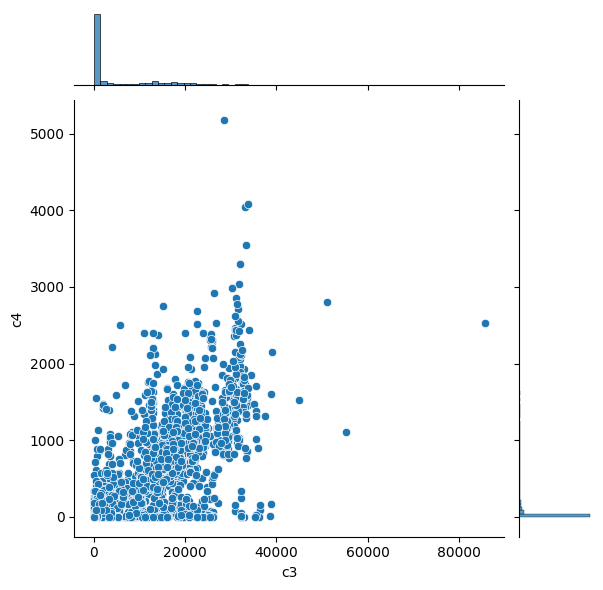

In [34]:
df = pd.DataFrame({'c3': c3counts, 'c4': c4counts})
sns.jointplot(df.sample(5000), x='c3', y='c4')

In [35]:
np.quantile(c3counts, np.linspace(0.1, 0.9, 9))

array([1.0000e+00, 9.0000e+00, 3.6000e+01, 1.1280e+02, 3.2400e+02,
       1.1500e+03, 8.5920e+03, 1.5486e+04, 2.1063e+04])

In [36]:
np.quantile(c4counts, np.linspace(0.1, 0.9, 9))

array([   0.,    0.,    0.,    3.,   13.,   49.,  215.,  578., 1000.])

In [37]:
c3_labels = np.array([1 if r[3] >= 324 else 0 for (i, r) in results])
c4_labels = np.array([2 if r[4] >= 1 else 0 for (i, r) in results])
labels = c3_labels + c4_labels

In [38]:
Counter(labels)

Counter({3: 410452, 0: 258368, 2: 179463, 1: 27430})

In [39]:
node_mapping = {node: i for i, node in enumerate(gw.nodes())}

H = nx.relabel_nodes(gw, node_mapping)

data = from_networkx(H)

data.x = torch.zeros(size=(H.number_of_nodes(), 1), dtype=torch.float)

data.y = torch.tensor(labels, dtype=torch.long)

torch.save(data, './data/web-google.pt')